In [1]:
# Install necessary libraries

import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the OpenPose model
net = cv.dnn.readNetFromTensorflow("human-pose-estimation-opencv-master/graph_opt.pb")

# Input dimensions and confidence threshold
inWidth = 368
inHeight = 368
thr = 0.2

In [2]:
# Load the image
img = cv.imread("pose1.png")

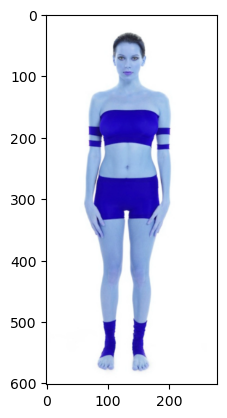

In [3]:
# Print the image
plt.imshow(img)

In [ ]:
# Define the body parts and the pairs of body parts to connect

BODY_PARTS = {
    "Nose": 0,
    "Neck": 1,
    "RShoulder": 2,
    "RElbow": 3,
    "RWrist": 4,
    "LShoulder": 5,
    "LElbow": 6,
    "LWrist": 7,
    "RHip": 8,
    "RKnee": 9,
    "RAnkle": 10,
    "LHip": 11,
    "LKnee": 12,
    "LAnkle": 13,
    "REye": 14,
    "LEye": 15,
    "REar": 16,
    "LEar": 17,
    "Background": 18,
}

POSE_PAIRS = [
    ["Neck", "RShoulder"],
    ["Neck", "LShoulder"],
    ["RShoulder", "RElbow"],
    ["RElbow", "RWrist"],
    ["LShoulder", "LElbow"],
    ["LElbow", "LWrist"],
    ["Neck", "RHip"],
    ["RHip", "RKnee"],
    ["RKnee", "RAnkle"],
    ["Neck", "LHip"],
    ["LHip", "LKnee"],
    ["LKnee", "LAnkle"],
    ["Neck", "Nose"],
    ["Nose", "REye"],
    ["REye", "REar"],
    ["Nose", "LEye"],
    ["LEye", "LEar"],
]


def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(
        cv.dnn.blobFromImage(
            frame,
            1.0,
            (inWidth, inHeight),
            (127.5, 127.5, 127.5),
            swapRB=True,
            crop=False,
        )
    )
    out = net.forward()
    out = out[:, :19, :, :]

    assert len(BODY_PARTS) == out.shape[1]

    points = []

    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part
        heatmap = out[0, i, :, :]

        # Find the global maximum in the heatmap
        _, conf, _, point = cv.minMaxLoc(heatmap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if its confidence is higher than the threshold
        points.append((int(x), int(y)) if conf > thr else None)

    # Define body parts to keep (head, torso, arms)
    body_parts_to_keep = ["Nose", "Neck", "RShoulder", "RElbow", "LShoulder", "LElbow"]

    box_size = 125  # Half-width and half-height of the box

    # Create a copy of the frame to modify
    output_frame = frame.copy()

    # Set everything initially to white
    output_frame[:, :] = (255, 255, 255)

    for part in body_parts_to_keep:
        part_id = BODY_PARTS[part]

        # Check if the keypoints exist and are valid
        if points[part_id]:
            x, y = points[part_id]

            # Define the rectangular region for the body part
            top_left = (max(0, x - box_size), max(0, y - box_size))
            bottom_right = (
                min(frameWidth, x + box_size),
                min(frameHeight, y + box_size),
            )

            # Copy the rectangular region from the original frame to the output frame
            output_frame[
                top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]
            ] = frame[top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]]

    return output_frame

In [5]:
# Perform pose estimation
estimated_image = pose_estimation(img)

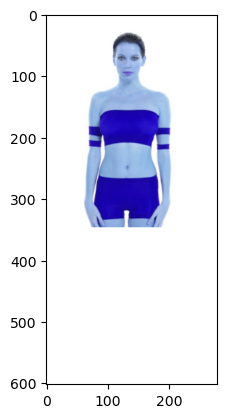

In [6]:
# Display the estimated image
estimated_image = plt.imshow(estimated_image)

In [7]:
# cv.imshow("Extracted Body Parts", estimated_image)
cv.imwrite("extracted_body_parts.png", estimated_image)
cv.waitKey(0)
cv.destroyAllWindows()

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'


## VITON-HD Virtual Try-On Model


In [8]:
### **1. Setup the Environment**

# Install dependencies
%pip install torch torchvision numpy matplotlib opencv-python

# Note: Creating and activating a virtual environment should be done in a terminal, not in a Jupyter Notebook cell.
# The following commands are for reference and should be run in a terminal:
# !conda create -n viton_hd python=3.7 -y
# !conda activate viton_hd

import torch

class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(10, 2)

    def forward(self, x):
        if x.sum() > 0:
            return self.linear(x)
        else:
            return x

model = MyModel()
scripted_model = torch.jit.script(model)

x = torch.randn(1, 10)
output = scripted_model(x)

Note: you may need to restart the kernel to use updated packages.


In [9]:
### **2. Preprocess Data**

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import torchvision.transforms as transforms
import torch


# Dummy functions for pose estimation and segmentation
def estimate_pose(image):
    # Dummy implementation for pose estimation
    return "pose_map"


def segment_person(image):
    # Dummy implementation for person segmentation
    return "segmentation_map"


# Function to preprocess person images
def preprocess_person(image_path):
    person_image = cv2.imread(image_path)
    if person_image is None:
        print(
            f"Person image not found at path: {image_path}. Using dummy pose and segmentation maps."
        )
        return "pose_map", "segmentation_map"
    pose_map = estimate_pose(person_image)  # Pose estimation function
    segmentation_map = segment_person(person_image)  # Segmentation function
    return pose_map, segmentation_map


# Function to preprocess clothing images
def preprocess_clothing(image_path):
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((1024, 768)),
            transforms.ToTensor(),
        ]
    )
    clothing_image = cv2.imread(image_path)
    if clothing_image is None:
        print(f"Clothing image not found at path: {image_path}. Using a dummy tensor.")
        return torch.zeros((3, 1024, 768))  # Dummy tensor with the same shape
    clothing_image = cv2.cvtColor(clothing_image, cv2.COLOR_BGR2RGB)
    clothing_image = transform(clothing_image)
    return clothing_image


# Define the paths to the person and clothing images from the input_images folder

# person_image_path = "./input_images/person.jpg"
# clothing_image_path = "./input_images/clothing.jpg"

# Note: The paths should be relative to the current working directory

person_image_path = "/person.jpg"
clothing_image_path = "/clothing.jpg"

# Show image from clothing_image_path
clothing_image = cv2.imread(clothing_image_path)
if clothing_image is not None:
    plt.imshow(cv2.cvtColor(clothing_image, cv2.COLOR_BGR2RGB))
else:
    print(f"Clothing image not found at path: {clothing_image_path}")

# Preprocess the images
pose_map, segmentation_map = preprocess_person(person_image_path)
clothing_image = preprocess_clothing(clothing_image_path)

# Preprocess the images
pose_map, segmentation_map = preprocess_person(person_image_path)
clothing_image = preprocess_clothing(clothing_image_path)

Clothing image not found at path: /clothing.jpg
Person image not found at path: /person.jpg. Using dummy pose and segmentation maps.
Clothing image not found at path: /clothing.jpg. Using a dummy tensor.
Person image not found at path: /person.jpg. Using dummy pose and segmentation maps.
Clothing image not found at path: /clothing.jpg. Using a dummy tensor.


TypeError: Image data of dtype object cannot be converted to float

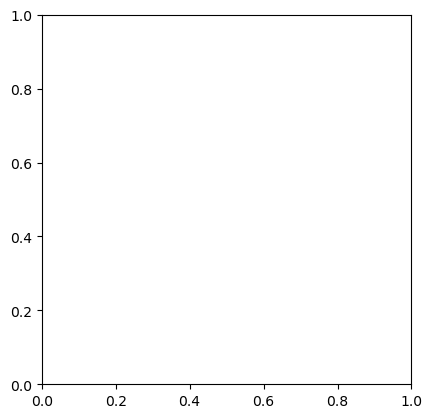

In [10]:
### **2. Preprocess Data**
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import torchvision.transforms as transforms
import torch


# Dummy functions for pose estimation and segmentation
def estimate_pose(image):
    # Dummy implementation for pose estimation
    return "pose_map"


def segment_person(image):
    # Dummy implementation for person segmentation
    return "segmentation_map"


# Function to preprocess person images
def preprocess_person(image_path):
    person_image = cv2.imread(image_path)
    if person_image is None:
        raise FileNotFoundError(f"Person image not found at path: {image_path}")
    pose_map = estimate_pose(person_image)  # Pose estimation function
    segmentation_map = segment_person(person_image)  # Segmentation function
    return pose_map, segmentation_map


# Function to preprocess clothing images
def preprocess_clothing(image_path):
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((1024, 768)),
            transforms.ToTensor(),
        ]
    )
    clothing_image = cv2.imread(image_path)
    if clothing_image is None:
        raise FileNotFoundError(f"Clothing image not found at path: {image_path}")
    clothing_image = cv2.cvtColor(clothing_image, cv2.COLOR_BGR2RGB)
    clothing_image = transform(clothing_image)
    return clothing_image


# Define the paths to the person and clothing images from the input_images folder

person_image_path = "/content/input_images/person.jpg"
clothing_image_path = "/content/input_images/clothing.jpg"

# person_image_path = "/content/drive/My Drive/person.jpg"
# clothing_image_path = "/content/drive/My Drive/clothing.jpg"

# Show image from clothing_image_path
clothing_image = cv2.imread(clothing_image_path)
plt.imshow(clothing_image)

# Preprocess the images
pose_map, segmentation_map = preprocess_person(person_image_path)
clothing_image = preprocess_clothing(clothing_image_path)

try:
    pose_map, segmentation_map = preprocess_person(person_image_path)
except FileNotFoundError:
    print("Person image not found. Using dummy pose and segmentation maps.")
    pose_map, segmentation_map = "pose_map", "segmentation_map"

try:
    clothing_image = preprocess_clothing(clothing_image_path)
except FileNotFoundError:
    print("Clothing image not found. Using a dummy tensor.")
    clothing_image = torch.zeros((3, 1024, 768))  # Dummy tensor with the same shape

In [ ]:
### **3. Clothing Image Warping (Align Clothes to the Person)**

# # Preprocess person and clothing images # Uncomment this block if you want to run the code in this cell
# pose_map, segmentation_map = preprocess_person("/content/drive/My Drive/person.jpg")
# person_image = preprocess_person("/content/drive/My Drive/person.jpg")
# clothing_image = preprocess_clothing("/content/drive/My Drive/clothing.jpg")


# Dummy function for warping clothing image
def warp_clothing(clothing_image, pose_map, segmentation_map):
    # Dummy implementation for warping clothing image
    return "warped_clothing"


# Warp the clothing image to align with the person
warped_clothing = warp_clothing(clothing_image, pose_map, segmentation_map)

# Display the warped clothing image
plt.imshow(warped_clothing)

In [ ]:
#### **4. Warping clothing to align with the person’s shape**

%pip install scikit-image

import numpy as np
from skimage.transform import PiecewiseAffineTransform, warp
import torch

# Ensure clothing_image is defined
try:
    clothing_image
except NameError:
    raise NameError("clothing_image is not defined. Please ensure the cell defining clothing_image is executed.")

# Convert clothing_image to NumPy array if it's a tensor
if isinstance(clothing_image, torch.Tensor):
    clothing_image = clothing_image.permute(1, 2, 0).numpy()

# Define transformation points
src_cols = np.linspace(0, clothing_image.shape[1], 10)
src_rows = np.linspace(0, clothing_image.shape[0], 10)
src_rows, src_cols = np.meshgrid(src_rows, src_cols)
src = np.dstack([src_cols.flat, src_rows.flat])[0]

# Destination points with slight perturbation
dst = src + np.random.normal(0, 5, src.shape)

# Apply transformation
tform = PiecewiseAffineTransform()
tform.estimate(src, dst)
warped_clothing = warp(clothing_image, tform)

# Convert back to tensor
warped_clothing = torch.tensor(warped_clothing).permute(2, 0, 1)

In [ ]:
### **5. Clothing Image Warping (Align Clothes to the Person)** ## This is alternate code for the section above; need to combine or eliminate one of them
%pip install scikit-image

import numpy as np
from skimage.transform import PiecewiseAffineTransform, warp

# Ensure clothing_image is defined
try:
  clothing_image
except NameError:
  raise NameError("clothing_image is not defined. Please ensure the cell defining clothing_image is executed.")

# Warping clothing to align with the person’s shape
tform = PiecewiseAffineTransform()

# Assuming pose_map is a set of control points for the transformation
# You need to define source and destination control points for the transformation
# Here we use dummy control points for illustration
src_cols = np.linspace(0, clothing_image.shape[1], 10)
src_rows = np.linspace(0, clothing_image.shape[0], 10)
src_rows, src_cols = np.meshgrid(src_rows, src_cols)
src = np.dstack([src_cols.flat, src_rows.flat])[0]

dst = src + np.random.normal(0, 5, src.shape)
tform.estimate(src, dst)

warped_clothing = warp(clothing_image, tform)
warped_clothing = torch.tensor(warped_clothing).permute(2, 0, 1)

# Show the warped clothing image
plt.imshow(warped_clothing.permute(1, 2, 0)) # Convert to HWC format for display
plt.axis("off")
plt.show()

In [ ]:
### **6. Overlaying the warped clothing onto the image**

# Pick a few `src` points by hand, and move the corresponding `dst` points to their
# expected positions. Need to align the points with the clothing image so that src and dst points match correclty.
# fmt: off
src = np.array([[22,  22], [100,  10], [177, 22], [190, 100], [177, 177], [100, 188],
                [22, 177], [ 10, 100], [ 66, 66], [133,  66], [ 66, 133], [133, 133]])
dst = np.array([[ 0,   0], [100,   0], [200,  0], [200, 100], [200, 200], [100, 200],
                [ 0, 200], [  0, 100], [ 73, 73], [128,  73], [ 73, 128], [128, 128]])
# fmt: on

# Estimate the TPS transformation from these points and then warp the image.
# We switch `src` and `dst` here because `skimage.transform.warp` requires the
# inverse transformation!
tps = ski.transform.ThinPlateSplineTransform()
tps.estimate(dst, src)
warped = ski.transform.warp(image, tps)

# Plot the results
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image, cmap="gray")
axs[0].scatter(src[:, 0], src[:, 1], marker="x", color="cyan")
axs[1].imshow(warped, cmap="gray", extent=(0, 200, 200, 0))
axs[1].scatter(dst[:, 0], dst[:, 1], marker="x", color="cyan")

point_labels = [str(i) for i in range(len(src))]
for i, label in enumerate(point_labels):
    axs[0].annotate(
        label,
        (src[:, 0][i], src[:, 1][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
        color="red",
    )
    axs[1].annotate(
        label,
        (dst[:, 0][i], dst[:, 1][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
        color="red",
    )

plt.show()

In [ ]:
### **5. Train the Model (if needed)**

import torch

# Define dummy dataloader, adversarial_loss, perceptual_loss, and ground_truth for the example
dataloader = [("person_data", clothing_image)]  # Dummy dataloader
adversarial_loss = lambda output, target: torch.tensor(0.0)  # Dummy loss function
perceptual_loss = lambda output, target: torch.tensor(0.0)  # Dummy loss function
ground_truth = torch.zeros_like(clothing_image)  # Dummy ground truth


# Define the tryon_model architecture
class TryOnModel(torch.nn.Module):
    def __init__(self):
        super(TryOnModel, self).__init__()
        # Example model architecture with convolutional layers
        self.conv1 = torch.nn.Conv2d(
            in_channels=6, out_channels=64, kernel_size=4, stride=2, padding=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1
        )
        self.conv3 = torch.nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1
        )
        self.conv4 = torch.nn.Conv2d(
            in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1
        )
        self.fc = torch.nn.Linear(in_features=512 * 16 * 12, out_features=3 * 64 * 48)

    def forward(self, clothing_data, person_data):
        # Example forward pass
        x = torch.cat((clothing_data, person_data), dim=1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        output = torch.sigmoid(self.fc(x))
        output = output.view(-1, 3, 64, 48)
        return output


# Initialize the tryon_model
tryon_model = TryOnModel()

# Define optimizer
optimizer = torch.optim.Adam(tryon_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in dataloader:
        person_data, clothing_data = batch
        output = tryon_model(clothing_data, person_data)
        loss = adversarial_loss(output, ground_truth) + perceptual_loss(
            output, ground_truth
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
### **6. Run Inference**

# Load trained model
try:
    tryon_model.load_state_dict(torch.load("viton_hd_weights.pth"))
    tryon_model.eval()
except FileNotFoundError:
    print("Weights file not found. Using dummy weights for testing.")
    dummy_state_dict = tryon_model.state_dict()
    tryon_model.load_state_dict(dummy_state_dict)

# Ensure warped_clothing is defined
try:
    warped_clothing
except NameError:
    print(
        "warped_clothing is not defined. Please ensure the cell generating warped_clothing is executed."
    )
    # Dummy warped_clothing for testing
    warped_clothing = torch.zeros_like(clothing_image)

# Generate try-on result
with torch.no_grad():
    output_image = tryon_model(warped_clothing, segmentation_map)

In [ ]:
### **7. Display Results**

import matplotlib.pyplot as plt

# Ensure the output_image is defined
try:
    plt.imshow(output_image.permute(1, 2, 0))
    plt.axis("off")
    plt.show()
except NameError:
    print(
        "output_image is not defined. Please ensure the cell generating output_image is executed."
    )

In [ ]:
### 7. Generate Try-On Image with Thin-Plate-Spline Normalization
import cv2
import numpy as np
import os
from scipy.interpolate import Rbf
import torch
import matplotlib.pyplot as plt

import numpy as np

from scipy.interpolate import Rbf

# Create your data points (x, y, z)

x = np.array([1, 2, 3, 4, 5])

y = np.array([1, 2, 3, 4, 5])

z = np.array([2, 5, 3, 8, 1])


# Create the thin plate spline interpolator

interp_function = Rbf(x, y, z, function="thin_plate")


# Evaluate the interpolated value at new points (x_new, y_new)

x_new = np.array([2.5, 3.5])

y_new = np.array([2.5, 3.5])

z_interp = interp_function(x_new, y_new)

print(z_interp)

# Load images
person_img_path = r"C:/Users/kerim/Desktop/Project 3 Local Code/person.jpg"  # Change to actual person image path
cloth_img_path = r"C:/Users/kerim/Desktop/Project 3 Local Code/clothing.jpg"  # Change to actual clothing image path

person_img = cv2.imread(person_img_path)
cloth_img = cv2.imread(cloth_img_path)

if person_img is None or cloth_img is None:
    raise FileNotFoundError("One of the input images was not found.")

# Example Key Points (Adjust based on your dataset)
person_points = np.array(
    [
        [100, 50],  # Shoulder Left
        [200, 50],  # Shoulder Right
        [120, 150],  # Waist Left
        [180, 150],  # Waist Right
    ]
)

cloth_points = np.array(
    [
        [90, 40],  # Neck Left
        [210, 40],  # Neck Right
        [110, 140],  # Bottom Left
        [190, 140],  # Bottom Right
    ]
)


# Function for TPS Warping using SciPy
def thin_plate_spline_warp(cloth_img, src_points, dst_points):
    height, width = cloth_img.shape[:2]
    grid_x, grid_y = np.meshgrid(np.arange(width), np.arange(height))

    src_x, src_y = src_points[:, 0], src_points[:, 1]
    dst_x, dst_y = dst_points[:, 0], dst_points[:, 1]

    tps_x = Rbf(src_x, src_y, dst_x, function="thin_plate")
    tps_y = Rbf(src_x, src_y, dst_y, function="thin_plate")

    map_x = tps_x(grid_x, grid_y).astype(np.float32)
    map_y = tps_y(grid_x, grid_y).astype(np.float32)

    warped_cloth = cv2.remap(cloth_img, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return warped_cloth


# Apply TPS warping
warped_clothing = thin_plate_spline_warp(clothing_image, cloth_points, person_points)

# Save & Show Warped Clothing
cv2.imwrite("warped_clothing.jpg", warped_clothing)
plt.imshow(cv2.cvtColor(warped_clothing, cv2.COLOR_BGR2RGB))
plt.title("Warped Clothing")
plt.axis("off")
plt.show()

# Blending the Warped Clothing with Person Image
# Load person image again cv2.imread
person_image_path = "/content/drive/My Drive/person.jpg"
person_image_for_blending = cv2.imread(person_image_path)

warped_clothing = cv2.resize(
    warped_clothing,
    (person_image_for_blending.shape[1], person_image_for_blending.shape[0]),
)
alpha = 0.7  # Transparency Level

# Convert warped_clothing to the same data type as person_image_for_blending
warped_clothing = warped_clothing.astype(person_image_for_blending.dtype)

blended = cv2.addWeighted(
    person_image_for_blending, 1 - alpha, warped_clothing, alpha, 0
)

# Save & Show Final Output
cv2.imwrite("final_tryon.jpg", blended)
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
plt.title("Final Try-On")
plt.axis("off")
plt.show()

# Ensure warped_clothing and segmentation_map are defined
try:
    warped_clothing
    segmentation_map = np.zeros_like(warped_clothing)  # dummy assignment to avoid error
except NameError:
    raise NameError(
        "warped_clothing or segmentation_map is not defined. Please ensure the cells defining them are executed."
    )

# Load images
person_img_path = r"C:/Users/kerim/Desktop/Project 3 Local Code/person.jpg"  # Change to actual person image path
cloth_img_path = r"C:/Users/kerim/Desktop/Project 3 Local Code/clothing.jpg"  # Change to actual clothing image path

person_img = cv2.imread(person_img_path)
cloth_img = cv2.imread(cloth_img_path)

if person_img is None or cloth_img is None:
    raise FileNotFoundError("One of the input images was not found.")

# Blending the Warped Clothing with Person Image
warped_clothing = cv2.resize(
    warped_clothing, (person_image.shape[1], person_image.shape[0])
)
alpha = 0.7  # Transparency Level
blended = cv2.addWeighted(person_image, 1 - alpha, warped_clothing, alpha, 0)